In [1]:
import pickle
from functools import partial

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow_probability as tfp
from tqdm import tqdm
from sbi_lens.config import config_lsst_y_10
from sbiax.nn import MomentNetwork

tfp = tfp.experimental.substrates.jax
tfb = tfp.bijectors
tfd = tfp.distributions

/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#load dataset 

dataset = np.load(
    "./data/LOADED&COMPRESSED_year_10_with_noise_score_conditional_very_large.npz",
    allow_pickle=True,
)["arr_0"]


inds = jnp.unique(jnp.where(jnp.isnan(dataset.item()["score"]))[0])
dataset_y = jnp.delete(dataset.item()["y"], inds, axis=0)
dataset_score = jnp.delete(dataset.item()["score"], inds, axis=0)
dataset_theta = jnp.delete(dataset.item()["theta"], inds, axis=0)

# train set
dataset_y_train = dataset_y[:len(dataset_score) - 2000]
dataset_score_train = dataset_score[:len(dataset_score) - 2000]
dataset_theta_train = dataset_theta[:len(dataset_score) - 2000]

# test set
dataset_y_test = dataset_y[len(dataset_score) - 2000:]
dataset_score_test = dataset_score[len(dataset_score) - 2000:]
dataset_theta_test = dataset_theta[len(dataset_score) - 2000:]

In [3]:
# training info 

total_steps = 5_000_000
sbi_method = 'nle'
batch_size = 256
params_name = config_lsst_y_10.params_name_latex

## Learn Marginal Score

In [4]:
nb_layer = 2

get_moments = hk.without_apply_rng(
    hk.transform_with_state(
        lambda theta, y : MomentNetwork(
            layers = [256]* nb_layer, 
            batch_norm = [hk.BatchNorm(True, True, 0.999) for i in range(nb_layer)]
        )(theta, y, is_training=True)
    )
)


get_moments_fixed = hk.without_apply_rng(
    hk.transform_with_state(
        lambda theta, y : MomentNetwork(
            layers = [256]* nb_layer, 
            batch_norm = [hk.BatchNorm(True, True, 0.999) for i in range(nb_layer)]
        )(theta, y, is_training=False)
    )
)

In [5]:
# loss and update functions 

@jax.jit
def loss_esperance(params, state_bn, theta, y, score):

  out, state_bn = get_moments.apply(params, state_bn, theta, y)

  return jnp.sum((out - score) ** 2, axis=-1).mean() / 1000, state_bn


@jax.jit
def update_esperance(params, opt_state, state_bn, theta, y, score):
    """Single SGD update step."""
    (loss, state_bn), grads = jax.value_and_grad(loss_esperance, has_aux = True)(
        params, state_bn, theta, y, score
    )
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state, state_bn

In [6]:
# training 

# init params
rng_seq = hk.PRNGSequence(12)
params_esperance, state_bn = get_moments.init(next(rng_seq), jnp.zeros([1, 6]), jnp.zeros([1, 6]))

# learning rate and optimizer
nb_steps = total_steps - total_steps * 0.5
lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=nb_steps // 60,
        decay_rate=0.9,
        end_value=1e-6,
    )
optimizer = optax.adam(lr_scheduler)
opt_state_esperance = optimizer.init(params_esperance)


batch_loss = []
val_loss = []
lr_scheduler_store = []
pbar = tqdm(range(total_steps + 1))

# training loop
for batch in pbar:
    
    inds = np.random.randint(0, len(dataset_score_train), batch_size)
    inds2 = np.random.randint(0, len(dataset_score_test), batch_size)
    
    ex_score = dataset_score_train[inds]
    ex_theta = dataset_theta_train[inds]
    ex_y = dataset_y_train[inds]

    l, params_esperance, opt_state_esperance, state_bn = update_esperance(
        params_esperance, opt_state_esperance, state_bn, ex_theta, ex_y, ex_score
    )

    if batch % 500 == 0:
        batch_loss.append(l)
        val_loss.append(
          loss_esperance(
              params_esperance, 
              state_bn,
              dataset_theta_test[inds2], 
              dataset_y_test[inds2],
              dataset_score_test[inds2]
          )[0]
        )
        lr_scheduler_store.append(lr_scheduler(batch))
        pbar.set_description(f"train loss {l:.3f}")

    if jnp.isnan(l):
        break

train loss 362.451: 100%|██████████| 5000001/5000001 [59:03<00:00, 1410.96it/s] 


In [7]:
# save NN params

with open(
   "./data/SNR_study/params_esp.pkl", "wb"
) as fp:
    pickle.dump(params_esperance, fp)

with open(
   "./data/SNR_study/state_bn_esp.pkl", "wb"
) as fp:
    pickle.dump(state_bn, fp)

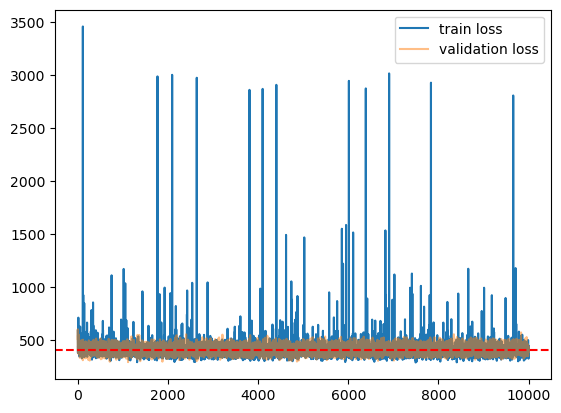

In [8]:
# plot losses

plt.plot(batch_loss, label = 'train loss')
plt.plot(val_loss, alpha = 0.5, label = 'validation loss')
plt.axhline(410, linestyle = '--', c = 'red')
plt.legend()

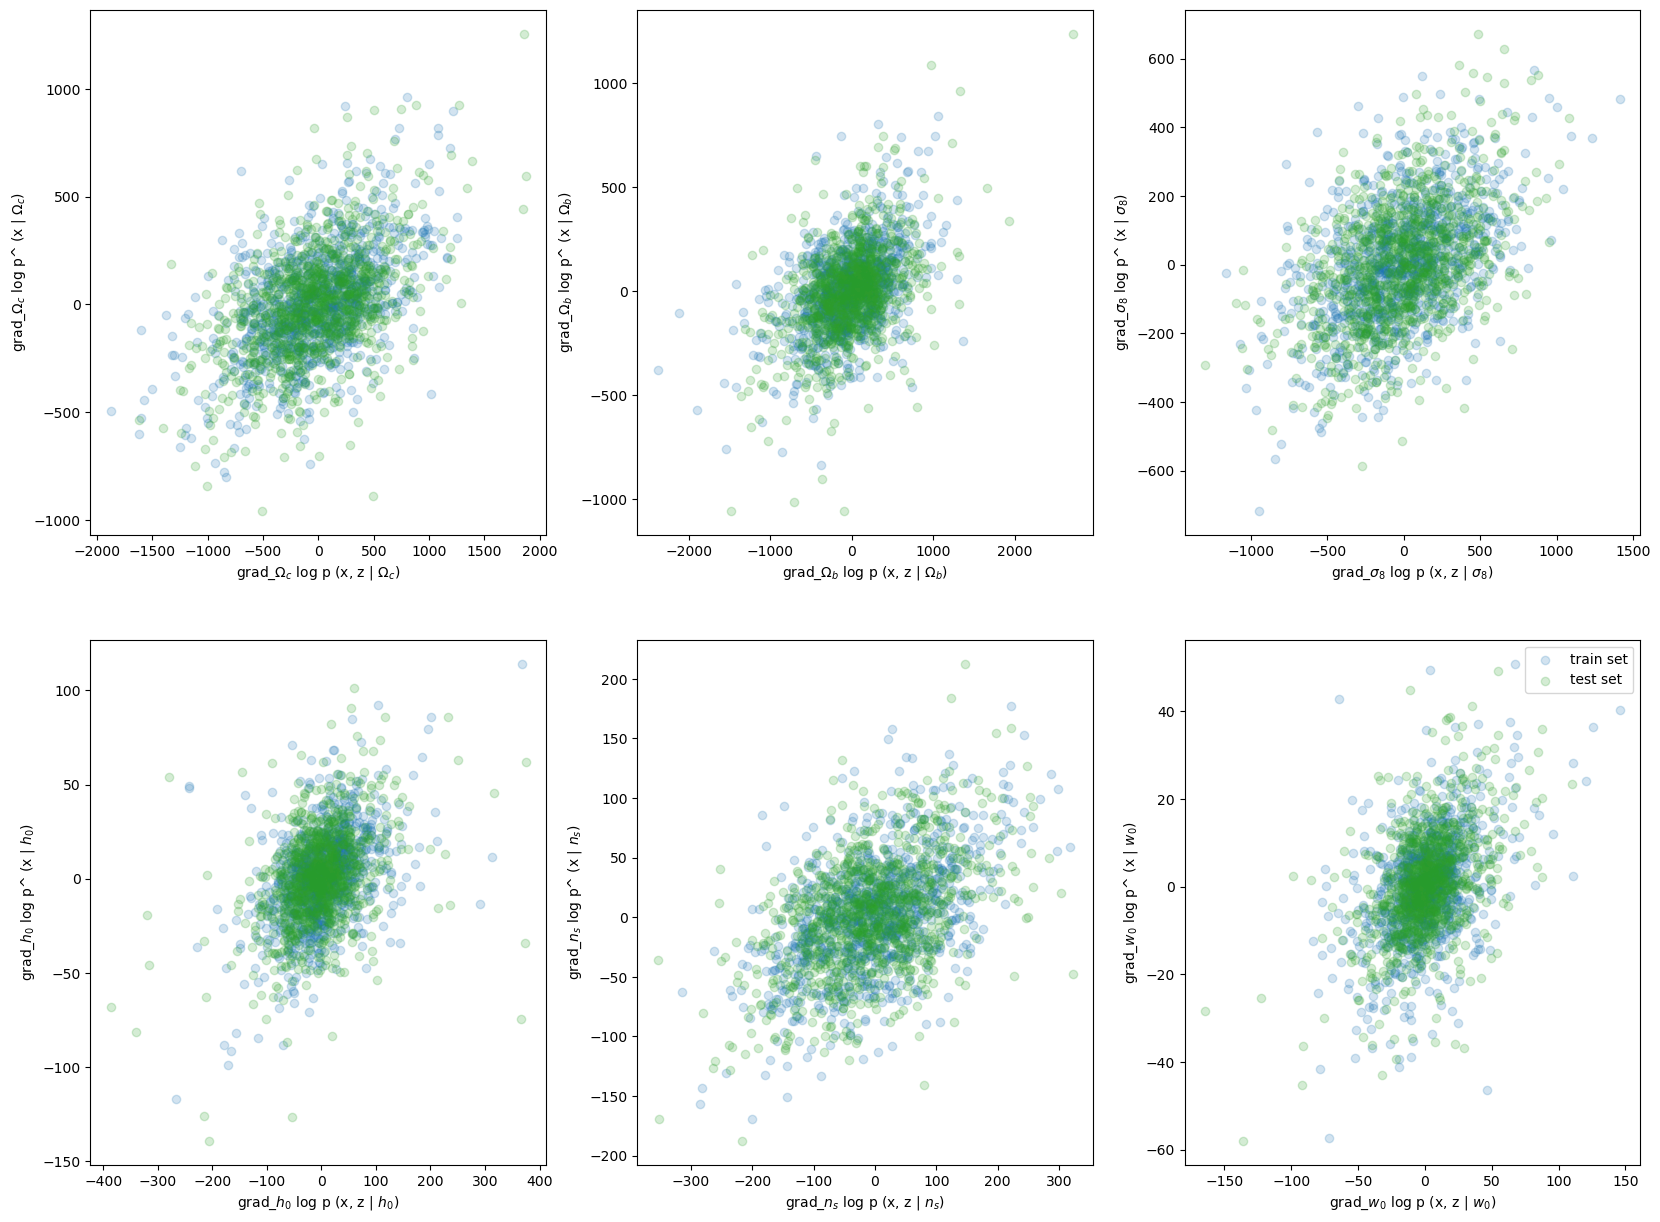

In [9]:
# check regression 

prediction1, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_test[:1000],
    dataset_y_test[:1000]
)

prediction2, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_train[:1000],
    dataset_y_train[:1000]
)

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(dataset_score_train[:1000][...,i], prediction2[...,i], alpha = 0.2, label = 'train set')
  plt.scatter(dataset_score_test[:1000][...,i], prediction1[...,i], alpha = 0.2, color = 'C2', marker = 'o', label = 'test set')
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))
    
plt.legend()

In [10]:
a_file =  open(
   "./data/SNR_study/params_esp.pkl", "rb"
) 

params_esperance = pickle.load(a_file)
    
a_file = open(
   "./data/SNR_study/state_bn_esp.pkl", "rb"
) 

state_bn = pickle.load(a_file)

## Check with $\nabla$ nle

In [11]:
# train NLE with "infinite" number of simulations 

from sbi_lens.normflow.models import AffineCoupling, ConditionalRealNVP
from snle import SNLE

# buil nde
bijector_layers = [128] * 2

bijector = partial(AffineCoupling, layers=bijector_layers, activation=jax.nn.silu)

NF = partial(ConditionalRealNVP, n_layers=4, bijector_fn=bijector)

class NDE(hk.Module):
    def __call__(self, y):
        return NF(6)(y)

    
nf_log_prob = hk.without_apply_rng(
        hk.transform(lambda theta, y: NDE()(theta).log_prob(y).squeeze())
    )

# init nde
params_init = nf_log_prob.init(
    jax.random.PRNGKey(87), 0.5 * jnp.ones([1, 6]), 0.5 * jnp.ones([1, 6])
)

# training 
inference = SNLE(NDE=nf_log_prob, init_params_nde=params_init, dim=6)

data = {"theta":dataset_theta[:50_000], "y":dataset_y[:50_000], "score": dataset_score[:50_000]}

lr_scheduler = optax.exponential_decay(
        init_value=0.001,
        transition_steps=500,
        decay_rate=0.9,
        end_value=1e-5,
)

inference.train(
  data,
  round_number=0,
  batch_size=128,
  score_weight=0, 
  learning_rate=lr_scheduler, 
)

nb of simulations used for training:  50000
... training nde
nb of epoch:  679
... done ✓


Text(0.5, 1.0, 'loss nle')

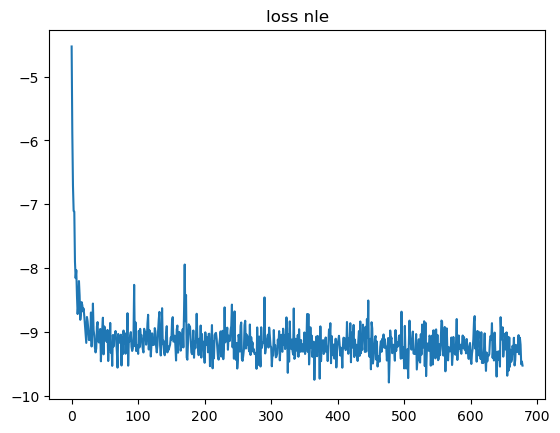

In [12]:
plt.plot(inference.loss)
plt.title('loss nle')

... running hmc
... done ✓


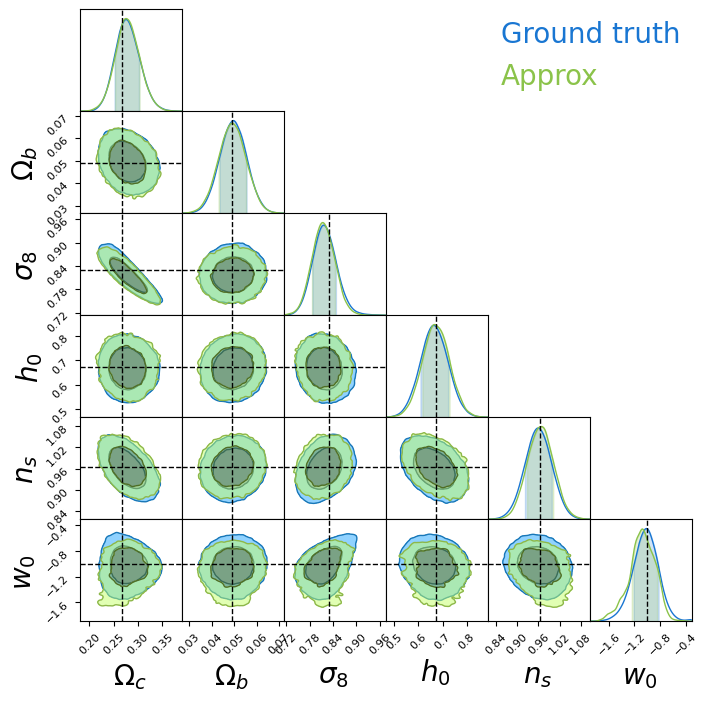

In [13]:
# check approximated posterior 

from utils import make_plot
from lensing_simulator_utils import CompressedSimulator
from sbi_lens.simulator.LogNormal_field import lensingLogNormal
from haiku._src.nets.resnet import ResNet18

N = config_lsst_y_10.N
map_size = config_lsst_y_10.map_size
sigma_e = config_lsst_y_10.sigma_e
gals_per_arcmin2 = config_lsst_y_10.gals_per_arcmin2
nbins = config_lsst_y_10.nbins
a = config_lsst_y_10.a
b = config_lsst_y_10.b
z0 = config_lsst_y_10.z0

truth = config_lsst_y_10.truth

params_name = config_lsst_y_10.params_name_latex

dim = 6

model = partial(
    lensingLogNormal,
    N=N,
    map_size=map_size,
    gal_per_arcmin2=gals_per_arcmin2,
    sigma_e=sigma_e,
    nbins=nbins,
    a=a,
    b=b,
    z0=z0,
    model_type="lognormal",
    lognormal_shifts="LSSTY10",
    with_noise=True,
)


compressor = hk.transform_with_state(lambda y: ResNet18(dim)(y, is_training=False))

a_file = open(
    "/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/params_compressor/opt_state_resnet_vmim.pkl",
    "rb",
)
opt_state_resnet = pickle.load(a_file)

a_file = open(
    "/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/params_compressor/params_nd_compressor_vmim.pkl",
    "rb",
)
parameters_compressor = pickle.load(a_file)

m_data = jnp.load(
    "/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/m_data__256N_10ms_27gpa_0.26se.npy"
)

m_data_comressed, _ = compressor.apply(
    parameters_compressor, opt_state_resnet, None, m_data.reshape([1, N, N, nbins])
)


compressed_simulator = CompressedSimulator(
    model=model,
    score_type='conditional',
    compressor=compressor,
    params_compressor=parameters_compressor,
    opt_state=opt_state_resnet,
)


init_mcmc = jnp.array(jnp.mean(compressed_simulator.prior_sample((1000,), jax.random.PRNGKey(78))))

posterior_sample = inference.sample(
    log_prob_prior=compressed_simulator.prior_log_prob,
    init=init_mcmc,
    observation=m_data_comressed,
    seed=jax.random.PRNGKey(0),
)
      
sample_ff = jnp.load(
    "/gpfswork/rech/eqw/ufa23yn/sbi_lens/sbi_lens/data/posterior_full_field__256N_10ms_27gpa_0.26se.npy"
)
                      
make_plot(
    [sample_ff, posterior_sample],
    ["Ground truth", "Approx"],
    params_name,
    truth,
)

In [14]:
# looks okay

In [15]:
@jax.vmap
def get_marginal_score(theta, y): 
    score = jax.grad(inference.log_prob_fn, argnums=1)(inference.params_nde, theta, y)
    return score

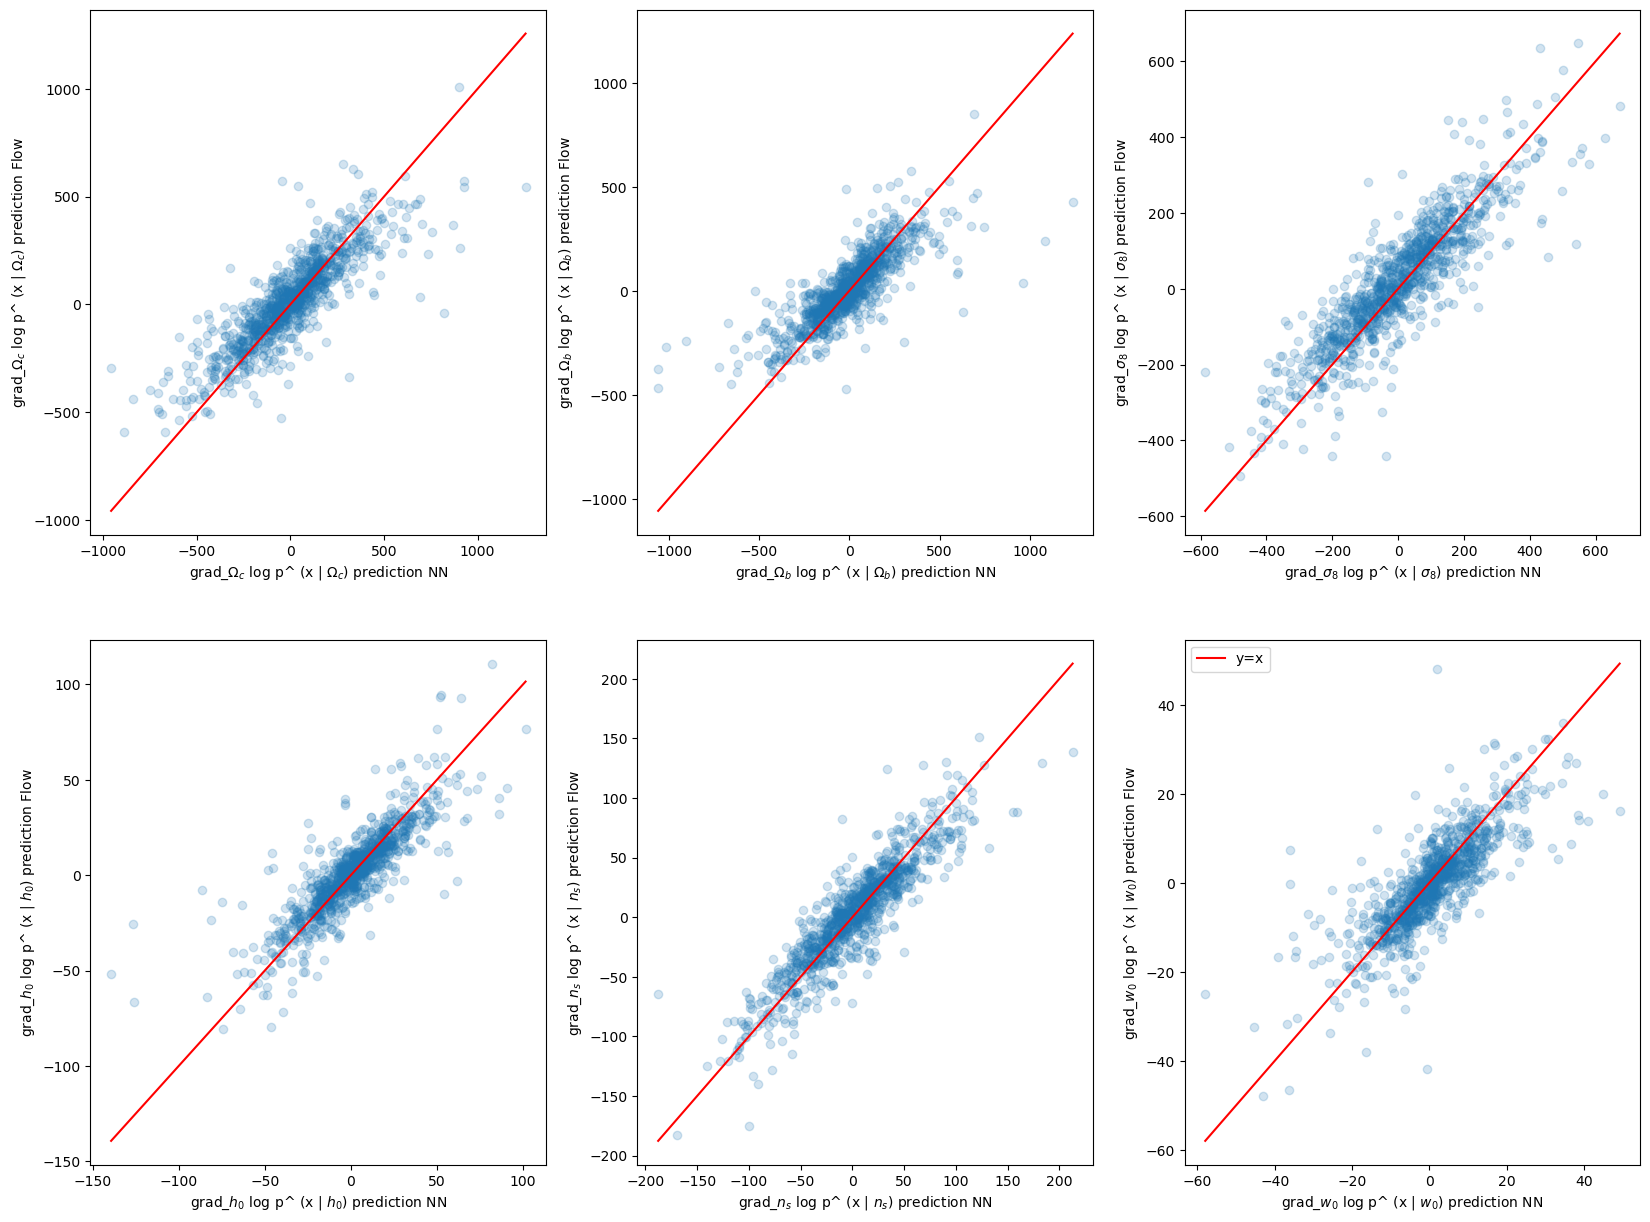

In [16]:
# compare learned marginal score to the gradient of nle

prediction1, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_test[:1000],
    dataset_y_test[:1000]
)

prediction2 = get_marginal_score(dataset_theta_test[:1000], dataset_y_test[:1000])

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.scatter(prediction1[...,i], prediction2[...,i], alpha = 0.2)
  min_pred = min(prediction1[...,i])
  max_pred = max(prediction1[...,i])
  plt.plot(jnp.linspace(min_pred, max_pred, 1000), jnp.linspace(min_pred, max_pred, 1000), color = 'red', label = 'y=x')
  plt.xlabel('grad_{} log p^ (x | {}) prediction NN'.format(params_name[i], params_name[i]))
  plt.ylabel('grad_{} log p^ (x | {}) prediction Flow'.format(params_name[i], params_name[i]))

plt.legend()

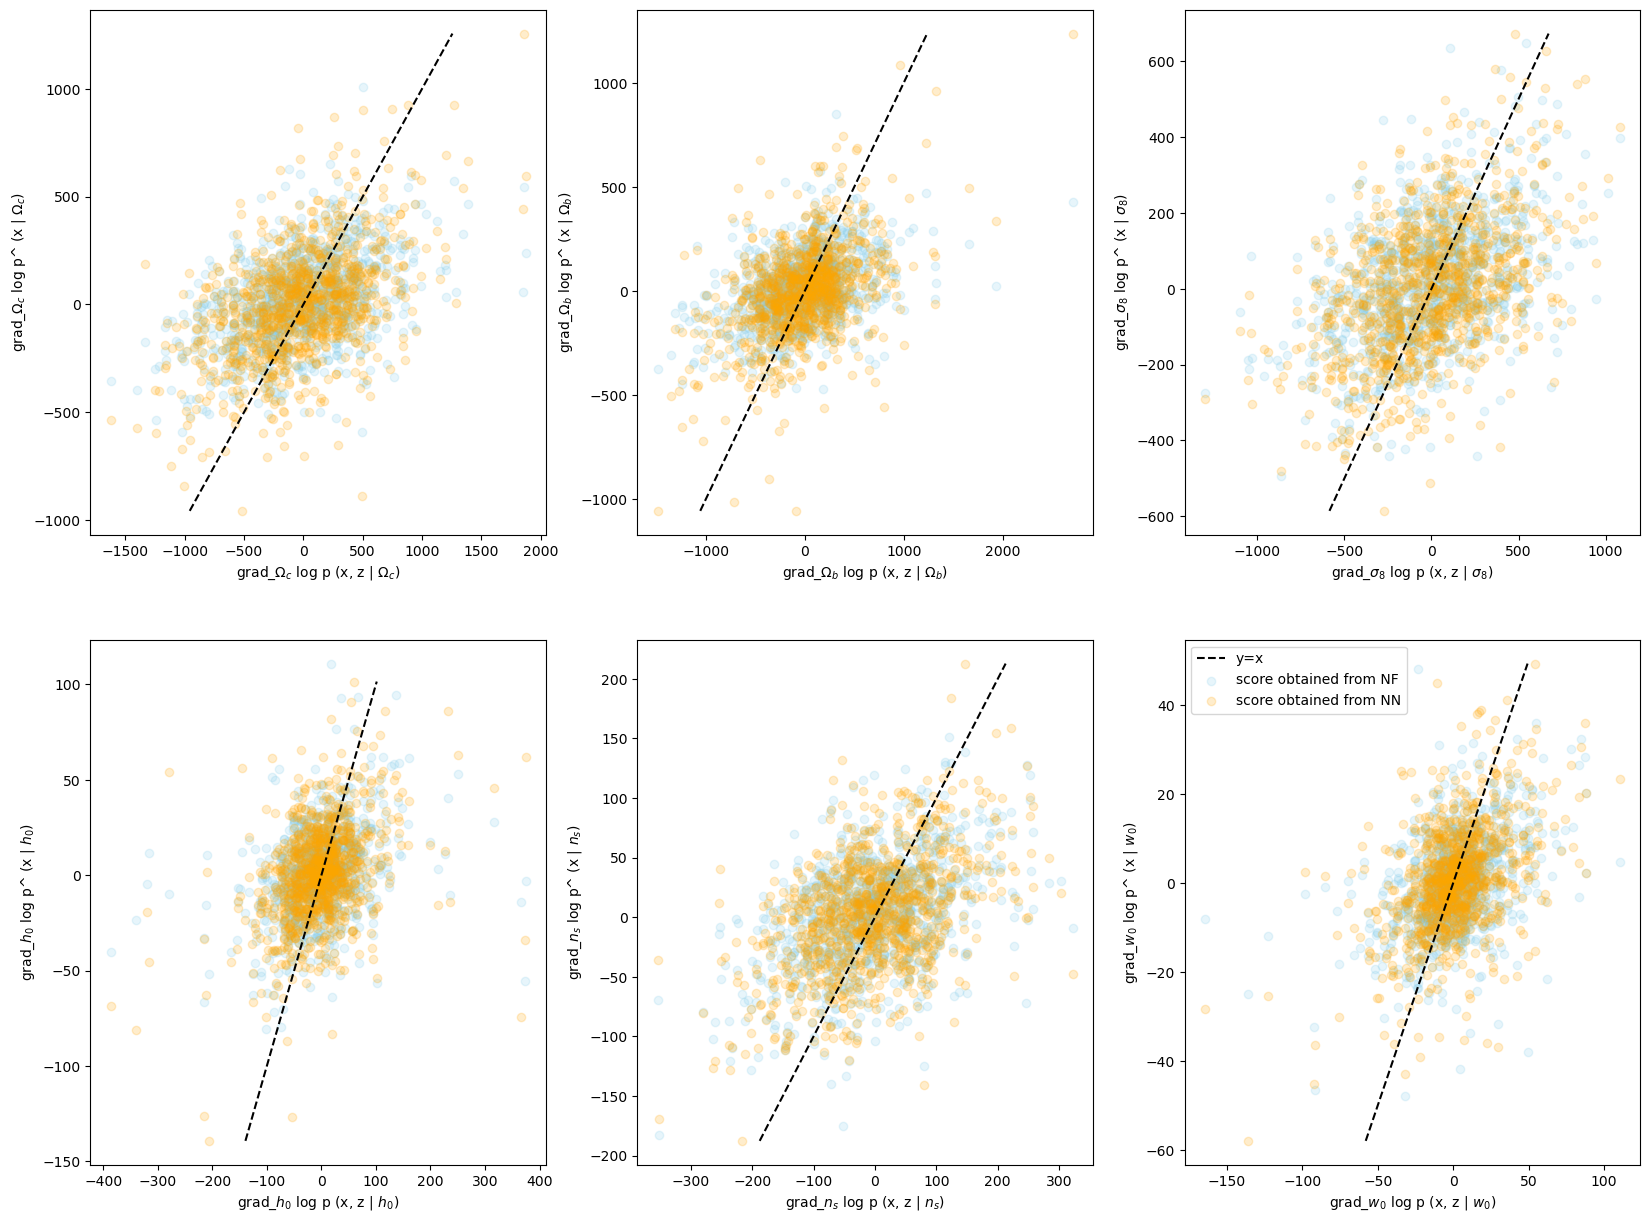

In [17]:
###### check regression on train set

prediction2, _ = get_moments_fixed.apply(
    params_esperance,  
    state_bn,
    dataset_theta_test[:1000],
    dataset_y_test[:1000]
)

prediction1 = get_marginal_score(dataset_theta_test[:1000], dataset_y_test[:1000])

plt.figure(figsize=(20, 15))
for i in range(6):
  plt.subplot(2,3,i+1)

  plt.scatter(dataset_score_test[:1000][...,i], prediction1[...,i], alpha = 0.2, color = 'skyblue', label = 'score obtained from NF')

  plt.scatter(dataset_score_test[:1000][...,i], prediction2[...,i], alpha = 0.2, color = 'orange', label = 'score obtained from NN')
  
  min_pred = min(prediction2[...,i])
  max_pred = max(prediction2[...,i])
  plt.plot(jnp.linspace(min_pred, max_pred, 1000), jnp.linspace(min_pred, max_pred, 1000), color = 'black', linestyle = '--', label = 'y=x')
  plt.ylabel('grad_{} log p^ (x | {})'.format(params_name[i], params_name[i]))
  plt.xlabel('grad_{} log p (x, z | {})'.format(params_name[i], params_name[i]))

plt.legend()